# K12深度学习的数学知识点（两层神经网络拟合二次方程数据）
1.张量、向量、矩阵概念：学习在PyTorch中生成随机二阶张量，即二维数组矩阵（矩阵伪数据）

2.矩阵相乘：python矩阵相乘运算符"@"     <br>   http://matrixmultiplication.xyz/

3.梯度下降，函数求导的概念

4.损失函数 loss function : 定义均方误差作为损失函数


5.Gradient Descent 梯度下降： PyTorch中梯度下降算法实施的细节<br>
**梯度下降** 是一个用于优化函数的算法。给定一个由一组参数决定的函数，梯度下降从一组初始的参数值开始，不断向能够最小化函数值的参数值迭代。这个迭代式最小化的结果是，通过向函数梯度的负方向不断递进而得到的。


# 随机梯度下降算法(SGD)

In [1]:
%matplotlib inline
from fastai.basics import *

在这部分，我们将会解释随机梯度下降算法(SGD)，它在神经网络应用中是常用的**优化**算法。我们将通过实例来解释其原理和概念。

##  Linear Regression problem 线性回归问题

线性回归的目标是将一条直线拟合到一组点。

In [2]:
n=300

In [3]:
x = torch.zeros(n,2) 
#x[:,0].uniform_(-1.,1)
x[:,0]=torch.linspace(-1.,1,300)


In [4]:
x[0]

tensor([-1.,  0.])

In [5]:
a = tensor([1.],[2.],[3.]); a;a.shape

torch.Size([3, 1])

In [6]:
y = 3*x[:,0]**2 + torch.rand(n)

In [7]:
x.shape

torch.Size([300, 2])

In [8]:
train_ds = TensorDataset(x, y);train_ds[299]


(tensor([1., 0.]), tensor(3.3532))

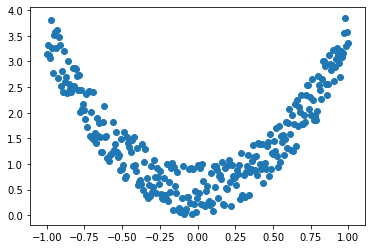

In [9]:
plt.scatter(x[:,0], y);

In [ ]:
n=100

In [ ]:
vx = torch.zeros(n,2) 
vx[:,0].uniform_(-1.,1)
vx[:2]

In [ ]:
vy = 3*vx[:,0]**2 + torch.rand(n)

In [ ]:
valid_ds = TensorDataset(vx, vy);valid_ds[99]


In [ ]:
plt.scatter(vx[:,0], vy);

你希望找到这样的 **参数**（权重） `a`，使得数据点和直线`x@a`之间的 *误差* 尽可能小。需要注意的是这里`a`是未知的。对于回归问题最常用的 *误差函数* 或者说 *损失函数* 是 **均方误差(MSE)** 。

In [10]:
def loss_func(y_hat, y): return ((y_hat-y)**2).mean()

假设我们取`a = (-1.0,1.0)`，那么我们就可以计算 *预测值* `y_hat` ，随后我们可以算出误差来。

到现在我们已经指定了 *模型*  的类型（线性回归），以及 *评估标准* （或者说 *损失函数* ），接下来我们需要处理 *优化*  过程；即，我们如何才能找到最优的`a`呢？我们如何才能找到 *拟合*  最好的线性回归模型呢？

# Gradient Descent 梯度下降

We would like to find the values of `a` that minimize `mse_loss`.<br>

我们希望找到最小化`mse_loss`值的`a`的值。

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.<br>

**梯度下降** 是一个用于优化函数的算法。给定一个由一组参数决定的函数，梯度下降从一组初始的参数值开始，不断向能够最小化函数值的参数值迭代。这个迭代式最小化的结果是，通过向函数梯度的负方向不断递进而得到的。

Here is gradient descent implemented in [PyTorch](http://pytorch.org/). <br>

这里是 [PyTorch](http://pytorch.org/)中梯度下降算法实施的细节。

In [32]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(2, 10, bias=True)
        self.lin2 = nn.Linear(10, 1, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [33]:
model = Mnist_NN().cpu()

In [ ]:
[p.shape for p in model.parameters()]

In [29]:
def update(x,y,lr):
    
    y_hat = model(x)
    # weight decay
    #w2 = 0.
    #for p in model.parameters(): 
    # add to regular loss
    loss = loss_func(y_hat, y) 
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [ ]:
def update(x,y,lr):
    opt = optim.SGD(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [ ]:
losses = [update(x,y,1e-1) for x,y in train_ds]

In [ ]:
plt.plot(losses);

In [ ]:
data = DataBunch.create(train_ds,valid_ds,bs=1)

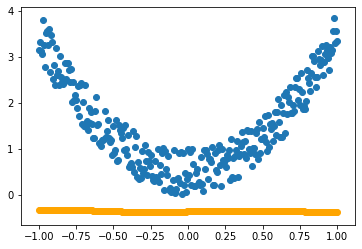

In [34]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],model(x),c='orange');

In [ ]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [ ]:
learn.fit(4)

In [ ]:
learn.fit_one_cycle(2)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2,max_lr=slice(1e-2))

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.recorder.plot_losses()

## Animate it! 过程动画化

In [15]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [35]:

fig = plt.figure()
plt.scatter(x[:,0], y)

lines, = plt.plot(x[:,0], model(x),c='orange', lw=5)
plt.close()

def animate(i):
    [update(x,y,1e-2) for x,y in train_ds]
   
    lines.set_ydata(model(x))
    return lines,

animation.FuncAnimation(fig, animate, np.arange(0, 60), interval=2)